### How do oxidation states of metals vary with changing anion?
# Torture the data

In [119]:
## IMPORTS
# Magic
%load_ext autoreload
%autoreload 2

# General
import json
from tqdm import tqdm
import os
from collections import Counter
import itertools
from datetime import datetime
import numpy as np
import re

# Pymatgen
from pymatgen import Specie, MPRester, Structure, Composition
from pymatgen.analysis.structure_prediction.substitutor import Substitutor
from pymatgen.io.cif import CifWriter

# SMACT
import smact
from smact import ordered_elements, neutral_ratios
from smact.screening import pauling_test 
from smact.oxidationstates import get_struc_list, mp_filter, species_count, sort_species, species_totals, \
find_instances, generate_scores, plot_all_scores, plot_metal, assign_prob, assign_prob_new, \
plot_scores_hist, ternary_smact_combos, predict_structure, add_probabilities

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
mpl.rc('font', **{ 'family' : 'serif', 'size' : 15, 'serif' : 'Times New Roman' })
mpl.rc('lines', **{ 'linewidth' : 2.0 })
mpl.rc('mathtext', **{ 'fontset' : 'custom', 'rm' : 'Times New Roman', 'it' : 'Times New Roman:italic', 'bf' : 'Times New Roman:bold' })

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
## FILES
# Set the path to your stash of cif files
cifpath = '/Users/Dan/Documents/Screening/Materials_Project/cifs/'

# Set the json file where the decorated pymatgen Structure objects are stored (as dicts)
json_file = 'decorated_structures.json'

In [121]:
# Import the structures from the desired json file
structure_list = get_struc_list(cifpath,json_file)

100%|██████████| 24376/24376 [00:32<00:00, 750.99it/s] 


In [122]:
# Add any additional filters based on MP data
# First filter to include anions of interest:
criteria = {'e_above_hull':{'$lt':0.1}, 'elements':{'$in':['O','S','Se','Te','F','Cl','Br','I']}}
filter_list = mp_filter(criteria)

# Second filter to include metals
criteria = {'elements':{'$in':smact.metals}}
filter_list2 = mp_filter(criteria)

structure_list = [i for i in structure_list if ( (i['id'] in filter_list) and (i['id'] in filter_list2) )]
print('Total number of structures after filter: {0}.'.format(len(structure_list)))

Total number of structures after filter: 17659.


In [123]:
# Work out all the different species present:
species_list = species_count(structure_list)
print('Total number of distinct species present: {0}'.format(len(species_list)))

Total number of distinct species present: 249


In [124]:
# Order elements by periodic table position or by oxidation states:
species_list = sort_species(species_list, 'ptable')

Species ordered by periodic table position.
First species: H-  last species: U6+


In [125]:
# Limit the list to metal species with +ve ox state as these are the ones we are interested in
species_list = [i for i in species_list if ((i.symbol in smact.metals) and (i.oxi_state > 0))]
print('Total number of metal species: {0}'.format(len(species_list)))

Total number of metal species: 165


In [126]:
# Get total numbers of compounds that feature each species
spec_totals = species_totals(structure_list)
# Also get the number of compounds that feature each element
element_totals = species_totals(structure_list, count_elements=True)

In [127]:
# Define a list of anions of interest
anions = []
for element, oxi_state in zip(['F','O','Cl','Br','I','S','Se','Te'], [-1,-2,-1,-1,-1,-2,-2,-2]):
    anions.append(Specie(element,oxi_state))

In [128]:
# Work out the number of compounds featuring each species when each anion is the most electronegative element present
most_eneg_an = {}
for an in tqdm(anions):
    most_eneg_an[an] = find_instances(an,structure_list)

100%|██████████| 8/8 [01:13<00:00,  8.22s/it]


Note: we now have these results in a dictionary of dictionaries.   
- The keys to the outer dictionary are anion `Species` objects. e.g. Specie F-   
- The keys to the inner dictionaries are all the other `Species` present when that anion is the most electronegative anion present
- The values are the number of compounds they appear in 

For 'scoring' below we can use:
- `spec_fraction` to get the distribution of each species across compounds by most e_neg anion present
    - **This is for the nice plots of qualitative trends**
- `an_norm` as above but divided by the total number of compounds containing that anion species as well as the metal species
- `spec_prob` to get the probability of a metal adopting a given oxidation state
    - **This is for quantitative analysis** 

In [129]:
# Generate a list of scores based on the data we've got for each anion
list_scores = generate_scores(species_list, most_eneg_an, spec_totals, el_totals=element_totals, scoring = 'spec_prob')

# Plot results

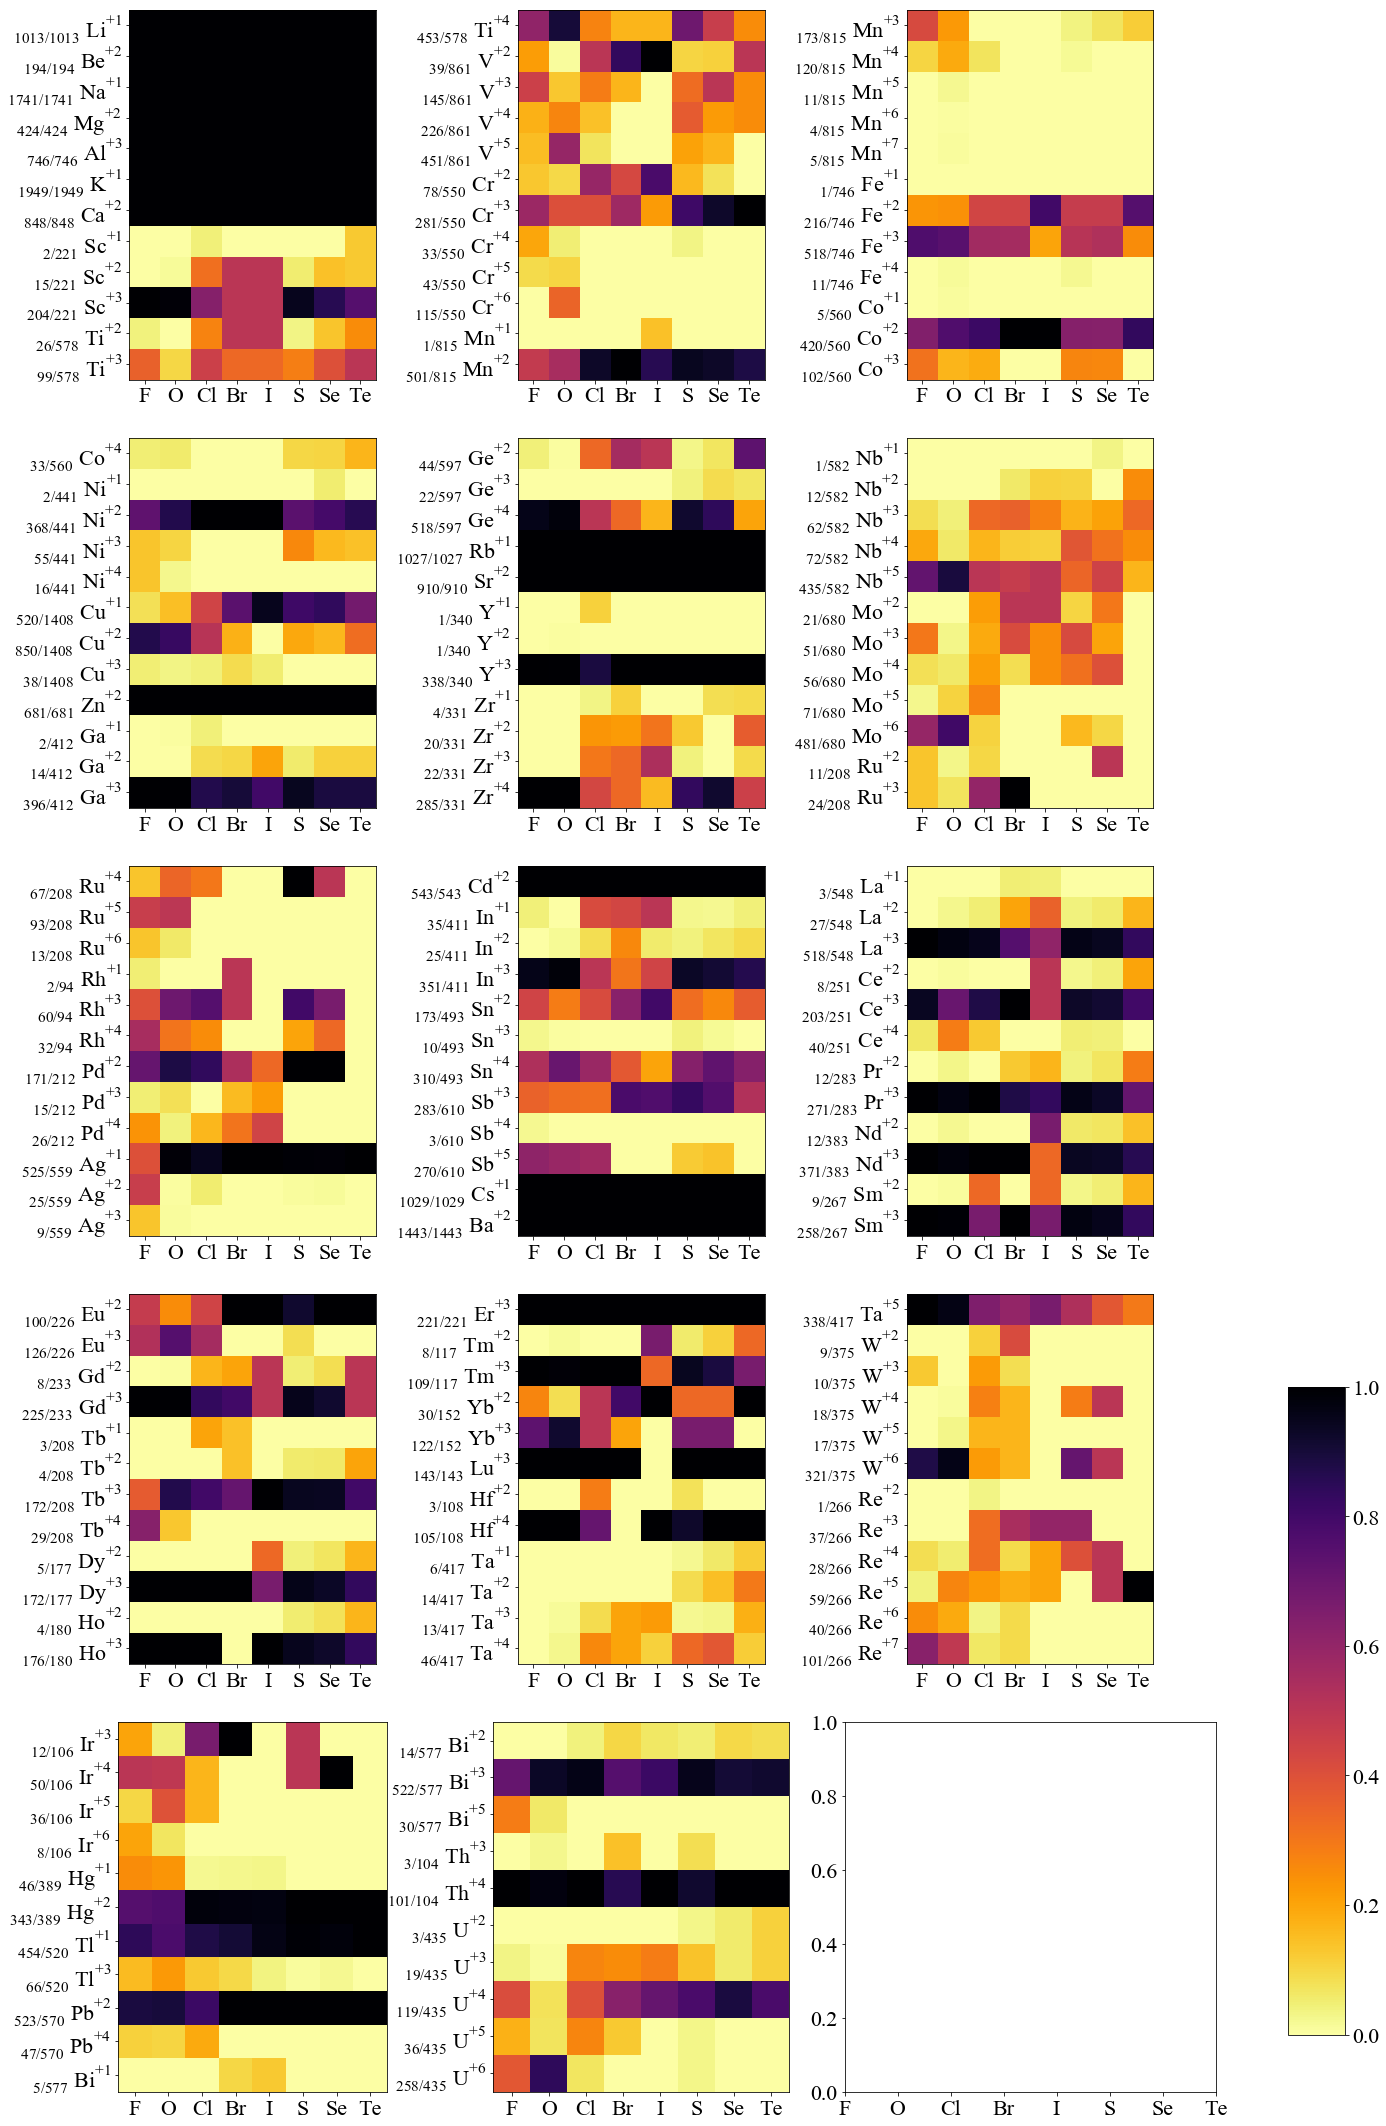

In [130]:
pylab.rcParams['figure.figsize'] = (20., 30.0)
mpl.rc('font', **{ 'family' : 'serif', 'size' : 22, 'serif' : 'Times New Roman' })
mpl.rc('lines', **{ 'linewidth' : 2.0 })
mpl.rc('mathtext', **{ 'fontset' : 'custom', 'rm' : 'Times New Roman', 'it' : 'Times New Roman:italic', 'bf' : 'Times New Roman:bold' })
break_points = [0, 12, 24, 36, # Points in the species list at which the next plot should start 
                48, 60, 72, 
                84, 96, 108, 
                120, 132, 144, 
                155, 165]
plot_all_scores(list_scores, species_list, break_points, figure_filename='ICSD_ox_states2.png', 
                raw_totals=[element_totals,spec_totals])

___

## Plot some trends for specific metals

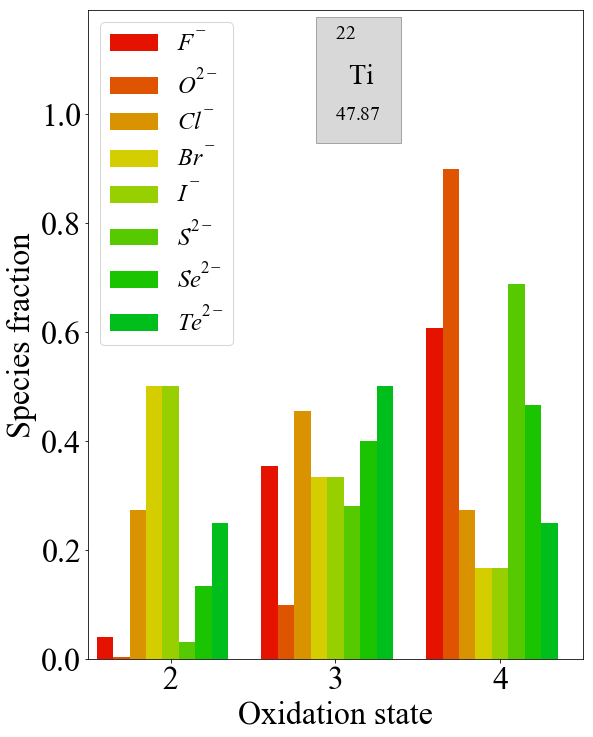

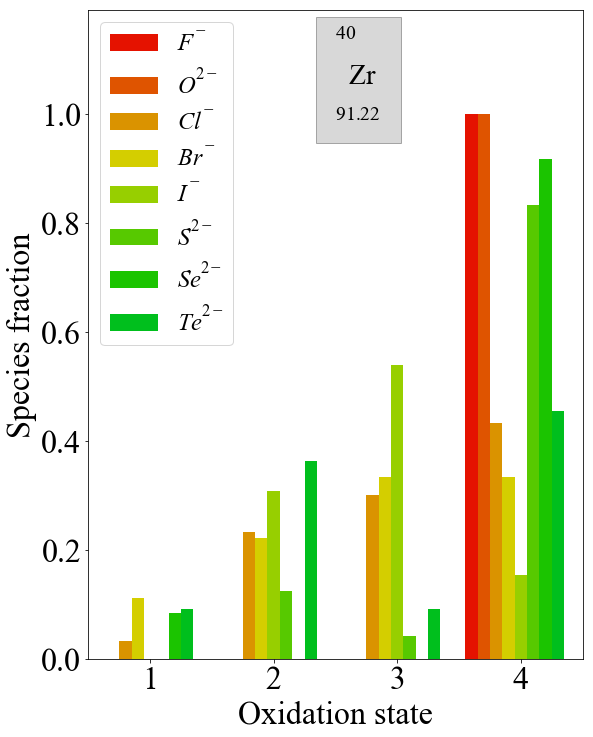

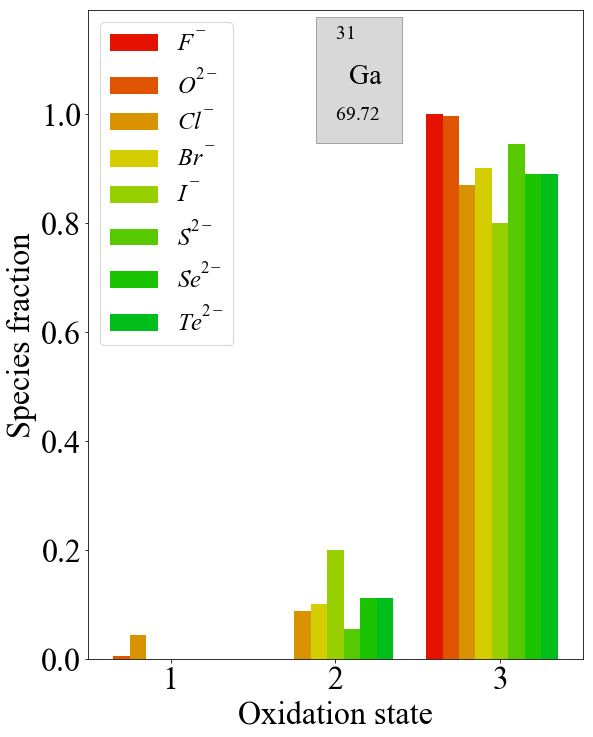

In [133]:
pylab.rcParams['figure.figsize'] = (9.0, 11.0)
mpl.rc('font', **{ 'family' : 'serif', 'size' : 32, 'serif' : 'Times New Roman' })
for mtl in ['Ti','Zr','Ga']:
    plot_metal(mtl, list_scores, species_list, show_legend=True)

# Prediction preliminaries

Number of individual values: 1320
Number of zero values: 411
Maximum score: 1.0


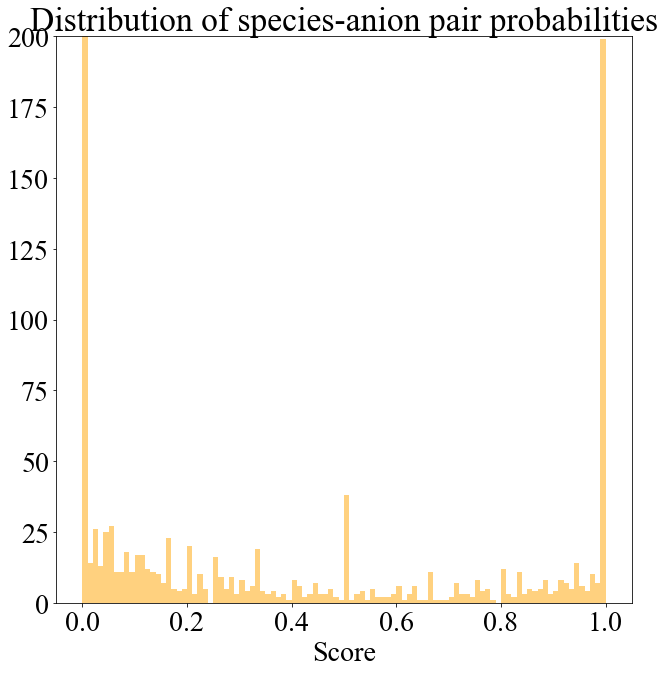

In [139]:
# Get distribtuion of scores in list_scores for each species-anion pair
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
mpl.rc('font', **{ 'family' : 'serif', 'size' : 28, 'serif' : 'Times New Roman' })
all_scores = [item for sublist in list_scores.values() for item in sublist]
plot_scores_hist(all_scores, plot_title='Distribution of species-anion pair probabilities',ylim=(0,200))

In [140]:
# Assign probabilities to all structures we have
# Can either be overall_score for np.mean() or limiting_score for min() or probability for np.product()
existing_probabilities = assign_prob(structure_list, list_scores, species_list, scoring='probability_simple')

100%|██████████| 17659/17659 [02:46<00:00, 105.97it/s]


Number of individual values: 16921
Number of zero values: 0
Maximum score: 1.0


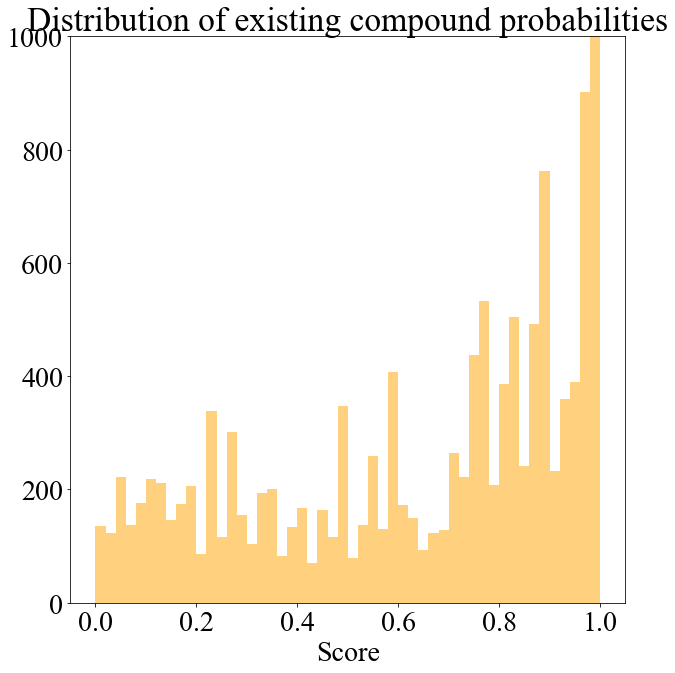

In [141]:
# Remove zero scores as these do not feature a desired species-anion combo
plotting_probabilities = [i for i in existing_probabilities if i != 0]
plot_scores_hist(plotting_probabilities, plot_title='Distribution of existing compound probabilities', bins=50,
                ylim=(0,1000))

## Do some modified SMACT compound generation
Modified because: 
1. We need to only consider -1 oxidation state of halogens
2. We need to know the oxidation states within each composition to work out the probability score

In [142]:
# Limit the search to 1st and second row transition metals with multiple oxidation states
tm_species_list = [i for i in species_list if i.symbol in smact.d_block]
halides = [Specie('F',-1), Specie('Cl',-1), Specie('Br',-1), Specie('I',-1)]

#Get combinations
smact_species_comps = ternary_smact_combos(tm_species_list, tm_species_list, halides)

37636it [00:15, 2501.95it/s]
  5%|▍         | 5168/108968 [00:00<00:02, 51673.27it/s]

Number of compositions before reduction:  108968
Converting to Pymatgen Species...


100%|██████████| 108968/108968 [00:01<00:00, 56128.99it/s]


Ditching duplicates (sorry to have got your hopes up with the big numbers)...
Total number of new compounds unique compositions: 54484


In [143]:
# Assign probabilities to each composition 
smact_comp_scores = assign_prob_new(smact_species_comps, list_scores, species_list, scoring='probability_simple')

100%|██████████| 54484/54484 [02:41<00:00, 337.55it/s]


Number of individual values: 54484
Number of zero values: 36320
Maximum score: 1.0


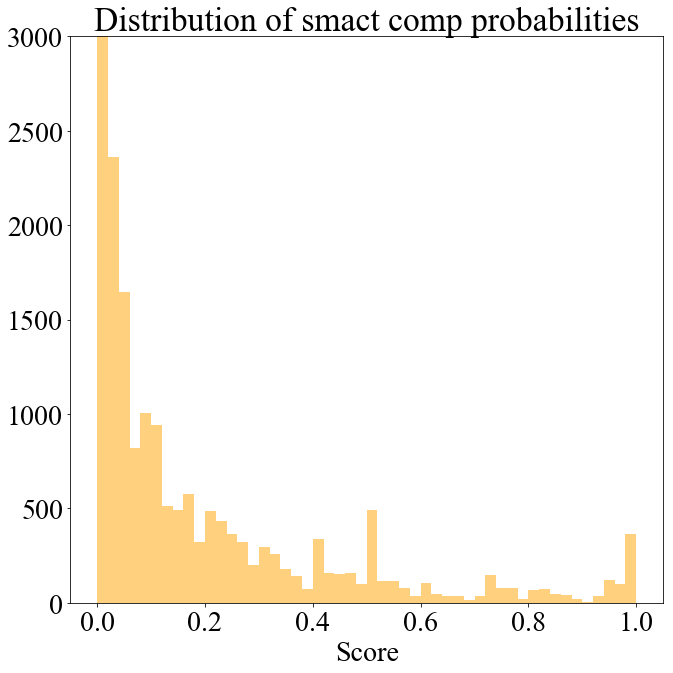

In [144]:
plot_scores_hist(smact_comp_scores, plot_title='Distribution of smact comp probabilities', bins=50, ylim=(0,3000))

In [145]:
# Combine compositions with scores
smact_species_comps = [{'composition': comp, 'score':score} for comp,score in zip(smact_species_comps,
                                                                                  smact_comp_scores)]

## Identify new compositions

In [146]:
# We want to focus on new chemical systems i.e. groups of elements that have never before 
# met in a compound
# Get all MPIDs and elements
existing_comps = mp_filter(criteria={'nelements': {'$gt':0}}, return_elements=True)

In [149]:
# Add an 'elements' key to the new compositions dict
for i in tqdm(smact_species_comps):
    i['elements'] = sorted(set([j.symbol for j in i['composition']]))
# Create a list of existing chemical systems 
existing_chemsys = []
for i in existing_comps:
    existing_chemsys.append(sorted(i['elements']))
# Compare
novel_comps = [i for i in smact_species_comps if i['elements'] not in existing_chemsys]
print('{0} out of {1} compounds are novel chemical systems'.format(len(novel_comps), len(smact_species_comps)))

100%|██████████| 54484/54484 [00:00<00:00, 96606.78it/s]

50208 out of 54484 compounds are novel chemical systems


## Plot threshold vs compounds

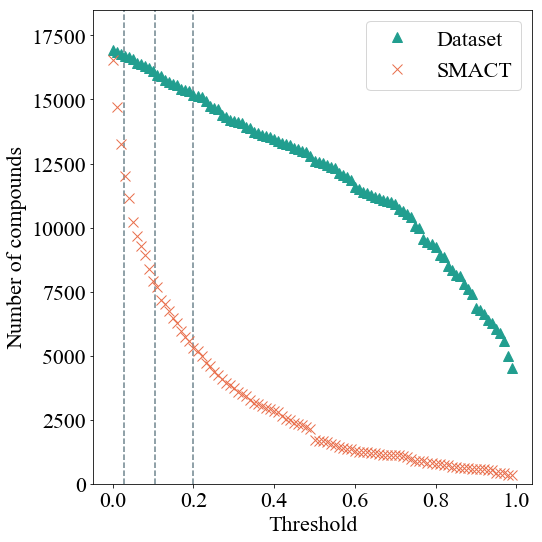

In [150]:
pylab.rcParams['figure.figsize'] = (8.0, 8.0)
mpl.rc('font', **{ 'family' : 'serif', 'size' : 22, 'serif' : 'Times New Roman' })
dataset_scores = plotting_probabilities
new_scores = [i['score'] for i in novel_comps]
dataset_totals = []
new_totals = []
x = np.arange(0,1,0.01)
for i in x:
    dataset_totals.append(len([x for x in dataset_scores if x > i]))
    new_totals.append(len([x for x in new_scores if x > i]))

fig, ax1 = plt.subplots()
#Plot existing compound totals in blue
ax1.plot(x,dataset_totals,'^', color='#219e8f', markersize=10, label = 'Dataset')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of compounds')#, color='b')
ax1.tick_params('y')#, colors='b')
plt.ylim(0.0,17500)
# Plot new composition totals in red
#ax2 = ax1.twinx()
#ax2.plot(x,new_totals, 'r.')
ax1.plot(x,new_totals, 'x',color='#e96f4c', markersize=10, label = 'SMACT')
#ax2.set_ylabel('New composition totals', color='r')
#ax2.tick_params('y', colors='r')
# Plot 99%, 95% and 90% threshold lines
plt.vlines(0.199, 0,50000, color='#254654', alpha=0.5, linestyles='dashed')
plt.vlines(0.105, 0,50000, color='#254654', alpha=0.5, linestyles='dashed')
plt.vlines(0.029, 0,50000, color='#254654', alpha=0.5, linestyles='dashed')
plt.ylim(0.0, 18500)
plt.legend()
fig.tight_layout()
plt.savefig('Scores_threshold_plot.png',dpi=300)
plt.show()

## Get highest scoring compounds and pass to structure predictor

In [152]:
# Do some sorting and print out top candidates
novel_comps = sorted(novel_comps, key=lambda x: x['score'], reverse=True) 
for i,c in enumerate(novel_comps):
    form = Composition(Counter(c['composition']))
    if c['score'] == 1.00:
        print('{0:4} ::  {1:10} :: {2:.2f}'.format(i,form.reduced_formula,c['score']))
    else: 
        break

   0 ::  Mn2NiBr6   :: 1.00
   1 ::  Ni2AgBr5   :: 1.00
   2 ::  Mn2RuBr7   :: 1.00
   3 ::  ZnCd3Br8   :: 1.00
   4 ::  Mn(Ag2Br3)2 :: 1.00
   5 ::  Cd2IrBr7   :: 1.00
   6 ::  ZnNi3Cl8   :: 1.00
   7 ::  YZn2F7     :: 1.00
   8 ::  NiAg3I5    :: 1.00
   9 ::  Hf(AgI2)4  :: 1.00
  10 ::  Mn3ZnBr8   :: 1.00
  11 ::  Ag2IrBr5   :: 1.00
  12 ::  CdAgBr3    :: 1.00
  13 ::  Hf(AgI3)2  :: 1.00
  14 ::  Zn2CdI6    :: 1.00
  15 ::  Zn(CoI3)2  :: 1.00
  16 ::  Co2RuBr7   :: 1.00
  17 ::  CdAg5Br7   :: 1.00
  18 ::  NiAgBr3    :: 1.00
  19 ::  CdCo3I8    :: 1.00
  20 ::  YCdI5      :: 1.00
  21 ::  Hf(ZnI4)2  :: 1.00
  22 ::  NiAg5I7    :: 1.00
  23 ::  V2Ag3I7    :: 1.00
  24 ::  MnCd3Br8   :: 1.00
  25 ::  AgRuBr4    :: 1.00
  26 ::  LaCdF5     :: 1.00
  27 ::  YZnBr5     :: 1.00
  28 ::  Zn3AgI7    :: 1.00
  29 ::  Ni2AgI5    :: 1.00
  30 ::  Zn3(AgBr4)2 :: 1.00
  31 ::  V(CoI3)2   :: 1.00
  32 ::  Cd2NiBr6   :: 1.00
  33 ::  YMn2Br7    :: 1.00
  34 ::  MnCo3Br8   :: 1.00
  35 ::  Co(RuBr4)

In [153]:
# Get all structures to substitute into
all_decorated_strucs = get_struc_list(cifpath,json_file)

100%|██████████| 24376/24376 [00:28<00:00, 843.79it/s] 


In [154]:
spec_sets_to_predict = [tuple(sorted(list(set(i['composition'])))) for i in novel_comps[:345]]
unique_spec_sets_to_predict = list(set(spec_sets_to_predict))
print('Number of unique species sets to pass to SP:  {0}'.format(len(unique_spec_sets_to_predict)))

Number of unique species sets to pass to SP:  88


<div class="alert alert-warning">
WARNING: The structure predictor below takes some time to run without parallelisation. You should only have to run the cell below once to generate the structures and save the cif files.
</div>

In [29]:
# Run structure predictor for all unique species sets
for spec in unique_spec_sets_to_predict:
    predict_structure(spec,all_decorated_strucs, check_dir=True)

(Specie Y3+, Specie Zn2+, Specie I-)  ........
Already exists
Done.
(Specie La3+, Specie Hf4+, Specie F-)  ........
Already exists
Done.
(Specie La3+, Specie Zn2+, Specie F-)  ........
Already exists
Done.
(Specie Y3+, Specie Hf4+, Specie I-)  ........
Already exists
Done.
(Specie Zn2+, Specie Ni2+, Specie Cl-)  ........
Already exists
Done.
(Specie Sc3+, Specie Zn2+, Specie F-)  ........
Already exists
Done.
(Specie Mn2+, Specie Zn2+, Specie Br-)  ........
Already exists
Done.
(Specie Mn2+, Specie Ir3+, Specie Br-)  ........
Already exists
Done.
(Specie La3+, Specie Ta5+, Specie F-)  ........
Already exists
Done.
(Specie Cd2+, Specie Ni2+, Specie Br-)  ........
Already exists
Done.
(Specie Mn2+, Specie Ru3+, Specie Br-)  ........
Already exists
Done.
(Specie Ir3+, Specie Ru3+, Specie Br-)  ........
Already exists
Done.
(Specie Cd2+, Specie Ir3+, Specie Br-)  ........
Already exists
Done.
(Specie V2+, Specie Cd2+, Specie I-)  ........
Already exists
Done.
(Specie Zn2+, Specie Cd2+, Spe

In [37]:
# Read all cif files in and convert to pymatgen structures
predicted_strucs = []
for root, subdirs, files in os.walk('SP_results/'):
    for file in files:
        if file.endswith('.cif'):
            struc = os.path.join(root,file)
            s = Structure.from_file(struc)
            based_on = file.split('_')[2].strip('.cif')
            predicted_strucs.append({'struc': s, 'formula':s.composition.reduced_formula,
                                    'based_on': based_on})

In [38]:
# Compare predicted structure formulas to those with high probabilities
promising_formulas = [Composition(Counter(i['composition'])).reduced_formula for i in novel_comps[:361]]
promising_strucs = [i for i in predicted_strucs if i['formula'] in promising_formulas]
print('Number of structures with promising formulas: {0}'.format(len(promising_strucs)))

Number of structures with promising formulas: 2540


In [39]:
# Add probabilities to structures
promising_strucs = add_probabilities(promising_strucs)

100%|██████████| 2540/2540 [00:00<00:00, 2569.09it/s]


## Rough area

In [ ]:
# List of metals used to construct PT figure
ordered_el = smact.ordered_elements(1,103)
individual_metals = []
for m in species_list:
    individual_metals.append(m.symbol)
individual_metals = list(set(individual_metals))
individual_metals.sort(key = lambda x: (ordered_el.index(x)))
with open('OxidationState_metals_considered.csv','w') as f:
    for m in individual_metals:
        f.write('{0}, 1.\n'.format(m))

In [ ]:
# List of anions for electroneg table
for s in anions:
    print(s.symbol,smact.Element(s.symbol).pauling_eneg)

In [ ]:
# Print anion totals
for anion in tqdm(anions):
    total = 0
    for i in structure_list:
        if anion in i['structure'].composition:
            # Check whether anion most electronegative element
            an_eneg = smact.Element(anion.symbol).pauling_eneg
            all_enegs = [smact.Element(sp.symbol).pauling_eneg for \
            sp in i['structure'].composition]
            if all(eneg <= an_eneg for eneg in all_enegs):
                total +=1
    print(anion,total)

In [ ]:
# Pull out chosen compositions from the novel_comps list
sp = [ Specie('Sc',3), Specie('Mn',4), Specie('I',-1) ]
for i,c in enumerate(novel_comps):
    form = Composition(Counter(c['composition']))
    if sp[0] in list(form.keys()):
        if sp[1] in list(form.keys()):
            if sp[2] in list(form.keys()):
                print('{0:4} ::  {1:10} :: {2:.3f} :: {3}'.format(i,form.reduced_formula,c['score'], form))

In [ ]:
# Threshold values for scatter plot
print(16735*.99)
print(16735*.95)
print(16735*.90)
for i, total_data, total_new in zip(x,dataset_totals, new_totals):
    print(i, total_data, total_new)